# Documentación de Consumo Promedio

El propósito de este documento es recorrer la teoría matemática y el código de ejecución para calcular el consumo promedio de un dispositivo Iot que monitorea un estanque.

In [15]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
import ast
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
from scipy.signal import medfilt

pd.set_option('mode.chained_assignment', None)

## Importar
El primer paso es importar las librerías necesarias.

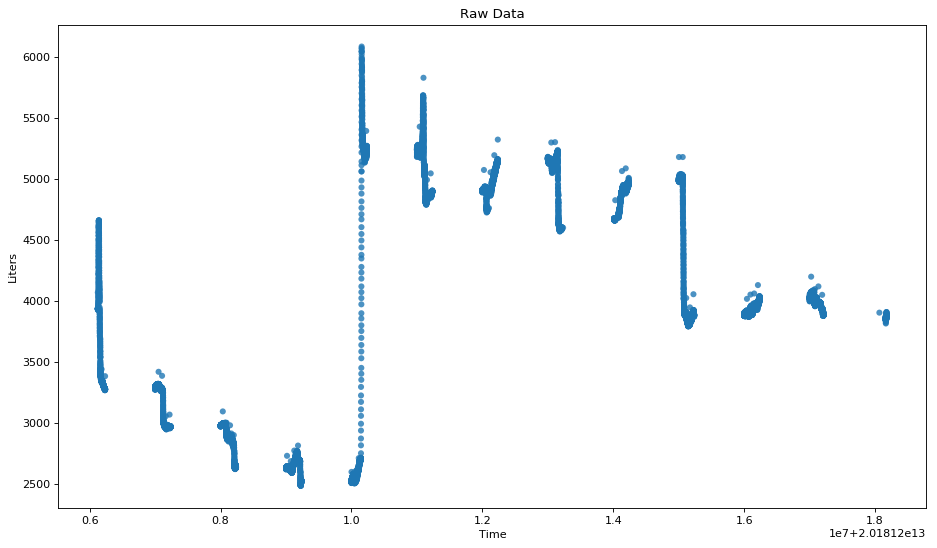

In [16]:

predict_event = {
  "startDate": 20181201080000,
  "endDate" : 20181231230000,
  "IotId":"francisco"}


url_base = "https://cceqzjbfdk.execute-api.us-west-2.amazonaws.com/test/"
url = url_base + "dummy/consumption?"

response = requests.get(url,  params=predict_event)
response_array = ast.literal_eval(response.text)
if response.status_code != 200:
    print(response.text)
    print(response.status_code)
data = ast.literal_eval(response.text)


plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(data['time'], data['liter'], alpha=0.8, edgecolors='none', s=30)
plt.title('Raw Data')
plt.xlabel("Time")
plt.ylabel("Liters")
plt.show()

## Los Datos

Arriba están los datos sin procesar extraídos de Elastic Search y reducidos para mostrar un máximo de un punto por minuto. La reducción de datos fue necesaria para reducir el ruido y evitar fallas en el sistema debido a los grandes requisitos de memoria y las cargas de datos excesivas.

In [17]:
df = pd.DataFrame(data={'liter': data['liter'], 'time': data['time']})
df['slope'] = df.liter.diff()
display(df.head(3))

,liter,time,slope
0,4070,20181206124201,NaN
1,3944,20181206124301,-126.0
2,3938,20181206124401,-6.0


## Calcule Pendiente

La pendiente (slope) o el cambio en litros para un paso de tiempo se calcula entre los puntos de datos.
La pendiente es equivalente de la m en la ecuación lineal _y = mx + b_

    y = valor en litros para una marca de tiempo
    y_previous = valor en litros para una marca de tiempo un paso antes de y

    slope = y - y_previous

Text(0, 0.5, 'Average Slope')

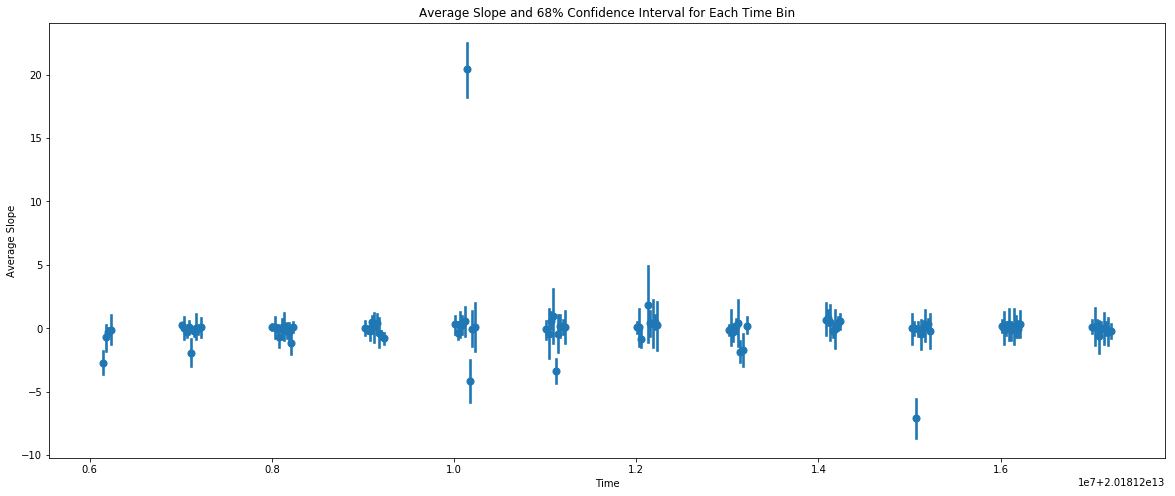

In [18]:
import seaborn as sns

plt.subplots(figsize=(20,8))
sns.regplot(x='time', y='slope', data=df.reset_index(), x_bins=100, ci=68, fit_reg=False)
plt.title('Average Slope and 68% Confidence Interval for Each Time Bin')
plt.xlabel("Time")
plt.ylabel("Average Slope")


## Coloque las Pendientes en Intervalos y Calcule el Intervalo de Confianza

En este punto, los datos se dividieron en 100 partes iguales de tiempo. Estas secciones se llaman "bins" o contenedores y contienen el conjunto de los datos que se produjeron entre la hora de inicio y la hora de la parada. Están representados en el gráfico arriba como un punto y una línea.

Los datos dentro de cada contenedor se promedian (el punto) y se calcula el intervalo de confianza para cada uno (la línea).

Esto nos dice cuál fue el consumo promedio para cada paso de tiempo y cuánta variación hubo entre los datos en ese paso. Cuando la variación entre los puntos de datos sea mayor el intervalo de confianza se vea mas grande, en cambio, si el intervalo de confianza fuera muy pequeño, significaría que el cambio en litros (la pendiente/slope) fue casi el mismo para todos los puntos en el paso del tiempo.


### Calcule los Intervalos de Confianza

    Intervalo de confianza alto = promedio + variable de porcentaje de confianza * desviación estándar / conteo ^ 2
    Intervalo de confianza bajo = promedio + variable de porcentaje de confianza * desviación estándar / conteo ^ 2
    
    o en ingles
    
    Confidence Interval High = average + percentage-confidence-variable*standard devation / count^2
    Confidence Interval Low = average + percentage-confidence-variable*standard devation / count^2
    
#### variable de porcentaje de confianza (percentage-confidence-variable)
son constantes que representan valores críticos de la tabla t (t-table) utilizada para calcular la probabilidad de que un valor caiga dentro o fuera de un rango, dado que los otros valores dentro del grupo sean conocidos.

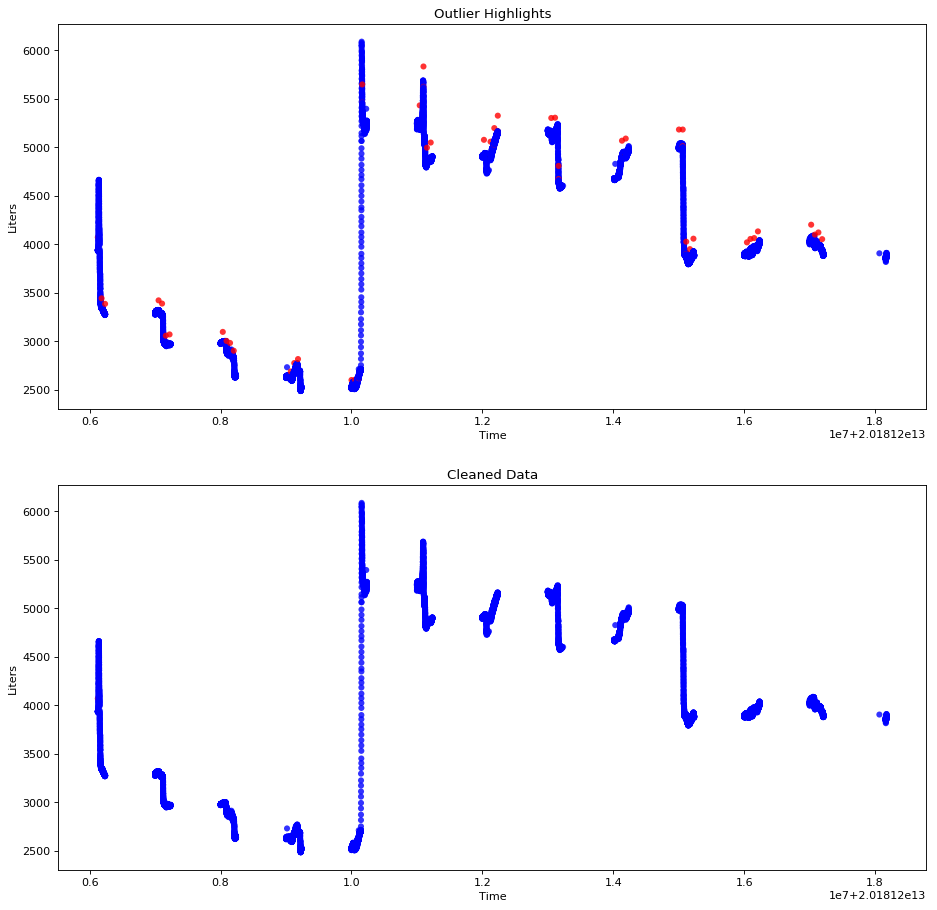

In [19]:

def identify_outliers(df, numB=100):

    df['bin'] = pd.cut(df.time, bins=numB, labels=False)
    bins = df.groupby(['bin'])['slope'].agg(['mean', 'count', 'std', 'sum'])
    bins['bin'] = df.bin.unique()

    ci_hi = []
    ci_lo = []
    for i in bins.index:
        m, c, s, summ, binn = bins.loc[i]
        ci_hi.append(m + 100.0*s/math.sqrt(c))
        ci_lo.append(m - 100.0*s/math.sqrt(c))

    bins['ci_hi'] = ci_hi
    bins['ci_lo'] = ci_lo

    labels = []
    color =[]
    previous_bin = -1

    try:
        for i, row  in df.iterrows():
            slope = row.slope
            if not np.isnan(slope):
                binn = row.bin
                if binn != previous_bin:
                    ci_hi = bins[bins['bin'] == binn].ci_hi.values[0]
                    ci_lo = bins[bins['bin'] == binn].ci_lo.values[0]
                    previous_bin = binn

                if slope >= ci_lo and slope <= ci_hi:
                    labels.append("normal")
                    color.append('b')

                else:
                    labels.append("outlier")
                    color.append('r')

            else:
                labels.append(np.nan)
                color.append('r')
    except Exception as e:
        print(i)
        raise(e)


    df['label'] = labels
    df['color'] = color
    
    return df, bins

df, bins = identify_outliers(df)


plt.figure(num=None, figsize=(14, 14), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(211)
plt.scatter(list(df.time), list(df.liter), alpha=0.8, c=list(df['color']), edgecolors='none', s=30)
plt.title('Outlier Highlights')
plt.xlabel("Time")
plt.ylabel("Liters")


df = df[df['label'] != 'outlier']
df.reset_index()

plt.subplot(212)
plt.scatter(list(df.time), list(df.liter), alpha=0.8, c=list(df['color']), edgecolors='none', s=30)
plt.title('Cleaned Data')
plt.xlabel("Time")
plt.ylabel("Liters")

plt.show()

## Identificar y Eliminar los Valores Atípicos.

Ahora que sabemos cómo se ve la mayoría de las pendientes (slopes) en un contenedor (bin), podemos identificar cuales que son raras o anormales. Si un dato está fuera del intervalo de confianza de un contenedor, se etiquetó como un valor atípico.

Después de ser etiquetados, los valores atípicos se eliminan del conjunto de datos para que no dañen los cálculos.





Text(0, 0.5, 'Liters')

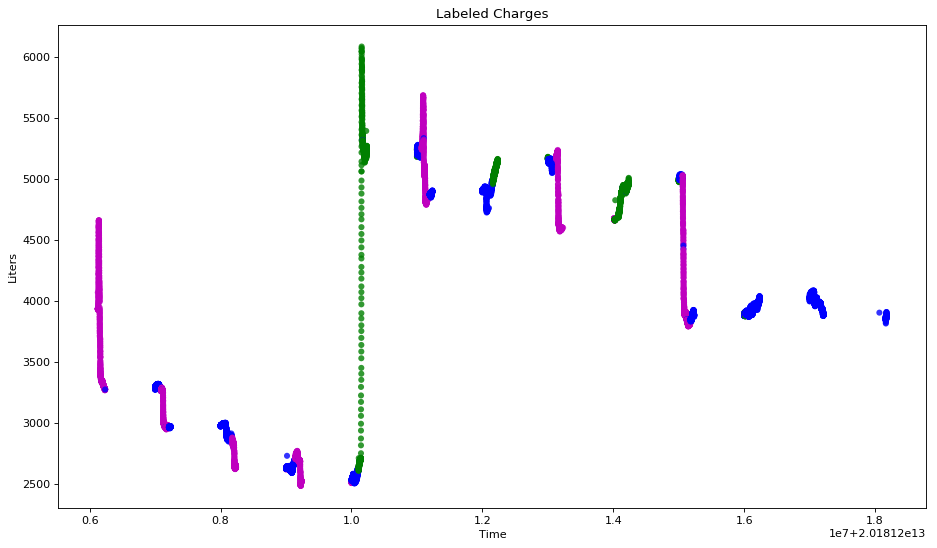

In [20]:
def label_charges(df, bins, threshold=0.25):
    labels = list(df.label)
    color = list(df.color)
    for i, row in df.iterrows():
        binn = row.bin
        if row.label != 'outlier':
            if bins['mean'][binn] >= threshold:
                labels[i] = 'recharge'
                color[i] = 'g'
            elif bins['mean'][binn] <= -threshold:
                labels[i] = 'discharge'
                color[i] = 'm'

    df['label'] = labels
    df['color'] = color
    return df

df = label_charges(df, bins)

plt.figure(num=None, figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

plt.scatter(list(df.time), list(df.liter), alpha=0.8, c=list(df['color']), edgecolors='none', s=30)
plt.title('Labeled Charges')
plt.xlabel("Time")
plt.ylabel("Liters")

## Etiquete los Cargos

Ahora que se han eliminado los valores atipicos, el resto de los datos se pueden etiquetar segun el comportamiento de su contenedor (bin).

Si la pendiente promedio (cambio en litros o cambio en el volumen del estanque) es positiva, el contenedor, y todos los datos dentro de ese contenedor, están etiquetados como recarga. (verde)

Si la pendiente promedio es negativa, el contenedor está etiquetado como descarga. (magenta)

Si la pendiente promedio está cerca de cero, al contenedor no se le asigna una etiqueta. (azul)


In [21]:

def model_averageDischarge(df, numB=5000, timestep=3600):
    
    
    df['bin'] = pd.cut(df.time, bins=numB, labels=False)
    df = df[df['label'] == 'discharge']
    
    dt = []
    dl = []
    previous_b = -1
    for i, row in df.iterrows():
        if row.bin != previous_b:
            stime = df[df['bin'] == row['bin']]['time'].values[0]
            sliter = df[df['bin'] == row['bin']]['liter'].values[0]
        dt.append(row['time'] - stime)
        dl.append(row['liter'] - sliter)
        previous_b = row.bin
    df['refTime'] = dt
    df['refLiter'] = dl
    

    pcoeff1 = np.polyfit(list(df.refTime), list(df.refLiter), 1)

    return pcoeff1[0]*timestep

discharges =[]
nums = []
for num in range(100,25000, 500):
    discharges.append(model_averageDischarge(df, num))
    nums.append(num)




Text(0, 0.5, 'Calculated Average Consumption (liters/hour)')

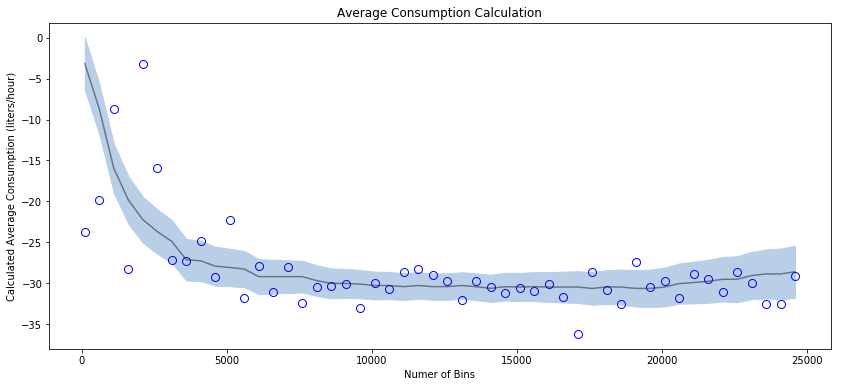

In [22]:

def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.

    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}

    References
    ----------
    .. [1]: M. Duarte.  "Curve fitting," JUpyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb

    """
    if ax is None:
        ax = plt.gca()

    ci = t*s_err*np.sqrt(1/n + (x2-np.mean(x))**2/np.sum((x-np.mean(x))**2))
    ax.fill_between(x2, y2+ci, y2-ci, color="#b9cfe7", edgecolor="")

    return ax

x = nums
y = discharges


def equation2(y):
    return medfilt(y, kernel_size=19)

p, cov = np.polyfit(x, y, 9, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
y_model = equation2(y)                                   # model using the fit parameters; NOTE: parameters here are coefficients

# Statistics
n = len(discharges)                                           # number of observations
m = p.size                                                 # number of parameters
dof = n - m                                                # degrees of freedom
t = stats.t.ppf(0.975, n - m)                              # used for CI and PI bands

# Estimates of Error in Data/Model
resid = y - y_model                           
chi2 = np.sum((resid/y_model)**2)                          # chi-squared; estimates error in data
chi2_red = chi2/(dof)                                      # reduced chi-squared; measures goodness of fit
s_err = np.sqrt(np.sum(resid**2)/(dof))                    # standard deviation of the error


# Plotting --------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 6))

# Data
ax.plot(
    x, y, "o", color="#b9cfe7", markersize=8, 
    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
)

# Fit
ax.plot(x,y_model,"-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")
best_guess = np.median(y)
#ax.plot(x, [best_guess]*len(y))

x2 = np.linspace(np.min(x), np.max(x), len(y))
y2 = equation2(y)#equation(p, x2)


# Confidence Interval (select one)
plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
plt.title('Average Consumption Calculation')
plt.xlabel("Numer of Bins")
plt.ylabel("Calculated Average Consumption (liters/hour)")



## Modele la Descarga Promedio

No podemos simplemente sumar las descargas y calcular el promedio. Cualquier punto de datos tiene algún error, por lo tanto, es una suposición incorrecta de que los bordes de las secciones de descarga son "verdad".

Por lo tanto, un enfoque mucho más preciso es dividir las secciones de descarga en pasos de tiempo (contenedores) y modelar una línea que represente el cambio en litros (pendiente / slope) para todos los pasos de tiempo.

Este enfoque también puede dar resultados muy diferentes según la ubicación de los puntos de inicio y parada de cada contenedor. El gráfico arriba muestra los diferentes cálculos para "Consumo promedio" según los diferentes tamaños de contenedores. Queremos elegir un tamaño de contenedor que nos di una predicción precisa para "Consumo promedio".

Al final, elegiremos un tamaño de contenedor entre 10000 y 20000 donde las predicciónes fueron relativamente consistente.


In [25]:
def create_timeRanges(df, bins, target):
    
    def merge_bins(bins):
        bins.reset_index(drop=True, inplace=True)
        intervals = []
        previous_bin =  bins['bin'][0]
        for i, row in bins.iterrows():
            binn = row.bin
            if binn == previous_bin + 1:
                intervals[-1].append(binn)
            else:
                intervals.append([binn])
            previous_bin = binn

        return intervals

    def extract_edges(df, intervals):
        t_intervals = []
        for interval in intervals:
            start, stop = df[df['bin'].isin(interval)].time.agg(['min', 'max'])
            t_intervals.append((start, stop))
        return t_intervals
    
    def reformat(intervals):
        master = []
        for interval in intervals:
            data = {"startDate": interval[0],
                     "endDate": interval[1]}
            master.append(data)
        return master

    target_bins = bins[bins['bin'].isin(df[df['label'] == target].bin.unique())]
    if len(target_bins) > 0:
        intervals = merge_bins(target_bins)
        t_interval = extract_edges(df, intervals)
        t_interval = reformat(t_interval)
    else:
        t_interval = []
    return t_interval

discharge_times = create_timeRanges(df.copy(), bins, 'discharge')
print("Discharge Time Ranges")
for time in discharge_times:
    print("      {}".format(time))



Discharge Time Ranges
      {'endDate': 20181206124601, 'startDate': 20181206124201}
      {'endDate': 20181206133014, 'startDate': 20181206131607}
      {'endDate': 20181206135929, 'startDate': 20181206135527}
      {'endDate': 20181206141329, 'startDate': 20181206140029}
      {'endDate': 20181206145244, 'startDate': 20181206143839}
      {'endDate': 20181206153024, 'startDate': 20181206152403}
      {'endDate': 20181206161426, 'startDate': 20181206160026}
      {'endDate': 20181206165326, 'startDate': 20181206163926}
      {'endDate': 20181206173126, 'startDate': 20181206172726}


## Defina Rangos de Tiempo

Después de que los  datos se hayan estado etiquetados, la fecha y hora de inicio y finalización de cada sección debe ser definido para pasar correctamente la información a través de la API.

La función create_timeRanges se inicia solo por los contenedores de la etiqueta del destino, por ejemplo "descarga". Luego recorre eses contenedores y extrae las fechas/hora de inicio y finalización de cada uno. Si encuentra que la fecha/hora de inicio de un contenedor es igual a la fecha/hora de finalización del contenedor anterior, las fusiona para crear un mega-contenedor. Este proceso continúa hasta que todos los contenedores hayan sido visitados. Posteriormente, los tiempos se reformatean para ajustarse a los estándares del API.
